### Notes
- what driving receipt of statement
- only need a human when someone picks up the phone

In [7]:
from pyspark.sql import SparkSession

spark = (
    SparkSession
    .builder
    .master('local[*]')
    .appName('PySparkShell')
    .getOrCreate()
)

# spark.conf.set('spark.sql.session.timeZone', 'UTC')
# spark.conf.set('spark.sql.session.timeZone', 'America/New_York')

In [8]:
import sys
import os

sys.path.append('/dbfs/cdr/library')

from pandas import set_option
set_option('display.max.columns', None)

# TODO: remove for Databricks
from dbutils import DBUtils, FileInfo
dbutils = DBUtils()

In [10]:
from sparkFunctions import create_tmp_parquet

from typing import Dict, List, Optional

# adds file system prefix /dbfs for local and dbfs: for databricks
def resolve(path: str) -> Optional[str]:
    try:
        prefix = dbutils.fs.ls('/')[0].path[:5]
        return prefix + path
    except Exception as error:
        print(error)

In [11]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import date_trunc, trim

from pyspark.storagelevel import StorageLevel

def truncateTimestamp(dataFrame: DataFrame) -> DataFrame:
    for column, dtype in dataFrame.dtypes:
        if dtype == 'timestamp':
            dataFrame = dataFrame.withColumn(column, date_trunc('second', column))
        
    return dataFrame


def trimString(dataFrame: DataFrame) -> DataFrame:
    for column, dtype in dataFrame.dtypes:
        if dtype == 'string':
            dataFrame = dataFrame.withColumn(column, trim(column))
        
    return dataFrame

In [12]:
FOLDER = '/automation'

ZOOM_FOLDER = os.path.join(FOLDER, 'ZoomData')
BASE_FOLDER = os.path.join(FOLDER, 'OnBase')

In [13]:
dbutils.fs.ls(BASE_FOLDER)

[FileInfo(path='/dbfs/automation/OnBase/cc_STStatementEmailDocs.parquet', name='cc_STStatementEmailDocs.parquet', size=25563408),
 FileInfo(path='/dbfs/automation/OnBase/rm_DVStatementRequestActivityRecords.parquet', name='rm_DVStatementRequestActivityRecords.parquet', size=97480388),
 FileInfo(path='/dbfs/automation/OnBase/rm_DVStatementRequests.parquet', name='rm_DVStatementRequests.parquet', size=51427694),
 FileInfo(path='/dbfs/automation/OnBase/rm_DVStatements.parquet', name='rm_DVStatements.parquet', size=40973701),
 FileInfo(path='/dbfs/automation/OnBase/rm_DVVendorContacts.parquet', name='rm_DVVendorContacts.parquet', size=24426383)]

In [14]:
from pyspark.sql.functions import col 

path = os.path.join(ZOOM_FOLDER, 'formattedAccountCallLogs.parquet')
calls = spark.read.parquet(resolve(path))


# Eastern Standard Time
calls = calls.withColumn('date_time', col('date_time_est').cast('timestamp')).drop('date_time_est')

integers = [
    'duration',
    'extension_number',
    'caller_number_type',
    'callee_number_type'
]

for column in integers:
    calls = calls.withColumn(column, col(column).cast('integer'))

calls = calls.withColumn('call_id', col('call_id').cast('long'))

drops = [
    'id',
    'path',
    'has_recording'
]

calls = calls.drop(*drops)

calls = truncateTimestamp(calls)
calls = trimString(calls)

In [15]:
%%time
from pyspark.sql.functions import regexp_extract

# outgoing calls begin with +1
# also use 1 for 1-800 numbers
# ones not found in VENDOR table

# ^ is anchor at start
# \+ escapes literal + sign in regular expression
# same with *, which is generally a wild card
pattern = r'^(\+1|\*)*([0-9]+)'

calls = (
    calls
    # extract second group using index=2
    .withColumn('CALLED_NUMBER', regexp_extract('callee_number', pattern, 2))
    .withColumn('RECEIVED_NUMBER', regexp_extract('caller_number', pattern, 2))
)

# calls = create_tmp_parquet(spark, calls, '/tmp/CALLS')

calls.persist(StorageLevel.DISK_ONLY)

calls.limit(5).toPandas()

CPU times: user 68.8 ms, sys: 34.5 ms, total: 103 ms
Wall time: 5.21 s


,caller_name,caller_number,callee_name,callee_number,direction,duration,date_time,call_end_time,result,call_id,extension_number,name,type,call_type,caller_number_type,callee_number_type,has_voicemail,date_time_end_est,CALLED_NUMBER,RECEIVED_NUMBER
0,None,+16169702069,Mitchell Malling,442,inbound,86,2021-09-17 11:05:47,None,Call connected,7008919107000321976,442,Mitchell Malling,user,voip,2,1,False,None,442,6169702069
1,Yodit Kahssai,474,None,+18552675551,outbound,139,2021-09-17 11:06:06,2021-09-17T15:08:27Z,Call connected,7008919188613195707,474,Yodit Kahssai,user,pstn,1,2,False,2021-09-17 11:08:27.000,8552675551,474
2,None,+16169702069,Nathan Gregorio,270,inbound,14,2021-09-17 11:07:00,None,Call connected,7008919416247491134,270,Nathan Gregorio,user,voip,2,1,False,None,270,6169702069
3,Dornier Medtech,+17705146253,Main Auto Receptionist,901,inbound,0,2021-09-17 11:07:03,None,No Answer,7008919433427273168,901,Main Auto Receptionist,autoReceptionist,voip,2,1,False,None,901,7705146253
4,Xavier Baron,852,Vssp,+16147195221,outbound,31,2021-09-17 11:07:07,2021-09-17T15:07:49Z,Call connected,7008919450606123974,852,Xavier Baron,user,pstn,1,2,False,2021-09-17 11:07:49.000,6147195221,852


In [87]:
# calls.groupBy('type').count().show()
# calls.groupBy('call_type').count().show()
# calls.groupBy('caller_number_type').count().show()
# calls.groupBy('callee_number_type').count().show()
# calls.groupBy('has_recording').count().show()
# calls.groupBy('has_voicemail').count().show()

In [16]:
%%time
path = os.path.join(BASE_FOLDER, 'rm_DVStatementRequestActivityRecords.parquet')
activities = spark.read.parquet(resolve(path))

dates = [
    'ActivityDate',
    'FollowUpDate'
]

for column in dates:
    activities = activities.withColumn(column, col(column).cast('date'))

# drops = [
#     'STNID',
#     'CustVendorObjectID'
# ]

# activities = activities.drop(*drops)
    
activities = truncateTimestamp(activities)
activities = trimString(activities)
    
# activities = create_tmp_parquet(spark, activities, '/tmp/ACTIVITIES')

activities.persist(StorageLevel.DISK_ONLY)
    
activities.limit(5).toPandas()

CPU times: user 48.5 ms, sys: 8.75 ms, total: 57.3 ms
Wall time: 25.4 s


,ObjectID,CreatedDate,ReferenceNumber,CustomerVendorName,JobNumber,JobName,ContactType,ActivityUser,ActivityDate,FollowUpDate,STNID,Notes,Outcome,ActivityType,CustVendorObjectID,VendorContactObjectID,StatementRequestObjectID,CreatedBy
0,28785475,2020-11-02 06:41:33,1279250,ULINE,3412,Carolinas Shared Service - 3412,Call,ASIBLEY,2020-11-01,2020-11-03,NaN,This is a test - Updated,None,None,21259327,NaN,25422522,ASIBLEY
1,28785637,2020-11-02 06:47:27,1279250,ULINE,3412,Carolinas Shared Service - 3412,Email,ASIBLEY,2020-11-01,2020-11-04,NaN,Test 2 - Updated,None,None,21259327,NaN,25422522,ASIBLEY
2,28786094,2020-11-02 06:52:58,1279250,ULINE,3412,Carolinas Shared Service - 3412,Client Email,ASIBLEY,2020-11-01,2020-11-03,NaN,Test 3,None,None,21259327,NaN,25422522,ASIBLEY
3,28838136,2020-11-04 12:47:58,1287154,BIOCOMPOSITES INC.,3435,The Christ Hospital - 3435,None,bwilliams1,2020-11-03,None,6192802.0,Statement Request creation skipped because thi...,None,None,27542411,NaN,27781594,ASIBLEY
4,28838138,2020-11-04 12:48:02,1225130,BONA FIDE COMMERCIAL SERVICES,3177,UC Health - 3177,None,jdagher,2020-11-03,None,6192806.0,Statement Request creation skipped because thi...,None,None,24317597,NaN,25860124,ASIBLEY


In [19]:
# activities.groupBy('Outcome').count().show(truncate=False)
# activities.groupBy('ActivityType').count().show(truncate=False)
# activities.groupBy('VendorContactObjectID').count().show(truncate=False)
# activities.groupBy('CreatedBy').count().show(truncate=False)
# activities.groupBy('STNID').count().show(truncate=False)

+-------------------------+-------+
|Outcome                  |count  |
+-------------------------+-------+
|Needs Account Number     |1458   |
|null                     |1180017|
|Verbal Zero Balance      |1953   |
|Left Voicemail           |51782  |
|Statement Received       |65787  |
|Remove From Scope        |5593   |
|Sent Authorization Letter|229406 |
|Needs Research           |5638   |
|Needs Supervisor         |7234   |
|Will Not Comply          |52142  |
|Need to Receive          |8436   |
|Needs Lead               |698    |
|Will Email or Fax        |9474   |
+-------------------------+-------+



In [20]:
%%time
path = os.path.join(BASE_FOLDER, 'rm_DVStatements.parquet')

statements = spark.read.parquet(resolve(path))

statements = truncateTimestamp(statements)
statements = trimString(statements)

statements.persist(StorageLevel.DISK_ONLY)

statements.limit(5).toPandas()

CPU times: user 52.8 ms, sys: 7.69 ms, total: 60.4 ms
Wall time: 9.44 s


,ReferenceNumber,JobNo,JobTier,StatementDate,DocumentHandle,ObjectID,CustVendorObjID,CustVendGroupObjID,CustVendGroupName,CustomerName,CID,CustVendName,CustVendNo,Volume,AccountsIdentified,Recon,EmailMessageID,CreatedDate,SRARObjectId
0,1074630,2600,NaN,2019-08-08 20:00:00,NaN,20482171,19080046,19080045,TEST - HILL-ROM COMPANY INC,"BSI Healthcare Audit Services, LLC",15121,TEST - HILL-ROM COMPANY INC,2340,2014673.00,NaN,NaN,0000000085C36CE5BB5D9244B44E28C87A7C112B070049...,2019-08-09 09:38:05,NaN
1,1074630,2600,NaN,2019-08-08 20:00:00,NaN,20482173,19080046,19080045,TEST - HILL-ROM COMPANY INC,"BSI Healthcare Audit Services, LLC",15121,TEST - HILL-ROM COMPANY INC,2340,2014673.00,NaN,NaN,0000000085C36CE5BB5D9244B44E28C87A7C112B070049...,2019-08-09 09:45:07,NaN
2,1074630,2600,NaN,2019-08-08 20:00:00,NaN,20482385,19080046,19080045,TEST - HILL-ROM COMPANY INC,"BSI Healthcare Audit Services, LLC",15121,TEST - HILL-ROM COMPANY INC,2340,2014673.00,NaN,NaN,0000000085C36CE5BB5D9244B44E28C87A7C112B070049...,2019-08-09 12:06:44,NaN
3,1074630,2600,NaN,2019-08-08 20:00:00,NaN,20482388,19080046,19080045,TEST - HILL-ROM COMPANY INC,"BSI Healthcare Audit Services, LLC",15121,TEST - HILL-ROM COMPANY INC,2340,2014673.00,NaN,NaN,0000000085C36CE5BB5D9244B44E28C87A7C112B070049...,2019-08-09 12:09:29,NaN
4,1157916,2936,1.0,2019-08-13 20:00:00,NaN,20512575,6523144,6523143,AMBU INC,Providence,12146,AMBU INC,25171,713229.48,NaN,NaN,00000000F643DA057DBD124B829A30CFCF400C1507002B...,2019-08-14 05:37:44,NaN


In [23]:
from sparkFunctions import duplicateRecords

keys = ['ReferenceNumber', 'JobNo']

duplicateRecords(statements, keys).sort(keys).limit(10).toPandas()

,ReferenceNumber,JobNo,JobTier,StatementDate,DocumentHandle,ObjectID,CustVendorObjID,CustVendGroupObjID,CustVendGroupName,CustomerName,CID,CustVendName,CustVendNo,Volume,AccountsIdentified,Recon,EmailMessageID,CreatedDate,SRARObjectId
0,1048708,2775,1,2020-02-06 19:00:00,16147286,23933146,15461478,15461477,LOGIQUIPLLC,BJC Healthcare,3208,LOGIQUIPLLC,0000000166,45716.38,NaN,NaN,00000000F643DA057DBD124B829A30CFCF400C1507002B...,2020-02-07 09:49:05,NaN
1,1048708,2775,1,2020-05-07 20:00:00,16380316,25514155,15461478,15461477,LOGIQUIPLLC,BJC Healthcare,3208,LOGIQUIPLLC,0000000166,45716.38,1.0,NaN,None,2020-05-08 05:48:43,NaN
2,1048708,2775,1,2020-08-08 20:00:00,16638632,27383707,15461478,15461477,LOGIQUIPLLC,BJC Healthcare,3208,LOGIQUIPLLC,0000000166,45716.38,0.0,NaN,00000000F643DA057DBD124B829A30CFCF400C1507002B...,2020-08-10 11:41:05,NaN
3,1048708,2775,1,2021-02-09 19:00:00,17150456,31287343,15461478,15461477,LOGIQUIPLLC,BJC Healthcare,3208,LOGIQUIPLLC,0000000166,45716.38,1.0,0.0,00000000F643DA057DBD124B829A30CFCF400C1507002B...,2021-02-11 06:45:25,NaN
4,1048708,2775,1,2021-04-19 20:00:00,17325841,33076063,15461478,15461477,LOGIQUIPLLC,BJC Healthcare,3208,LOGIQUIPLLC,0000000166,45716.38,1.0,1.0,00000000F643DA057DBD124B829A30CFCF400C1507002B...,2021-04-20 07:07:34,NaN
5,1048708,2775,1,2021-05-12 20:00:00,17397837,33746135,15461478,15461477,LOGIQUIPLLC,BJC Healthcare,3208,LOGIQUIPLLC,0000000166,45716.38,1.0,0.0,00000000F643DA057DBD124B829A30CFCF400C1507002B...,2021-05-14 12:34:54,NaN
6,1048708,2775,1,2021-06-22 20:00:00,17499474,34734261,15461478,15461477,LOGIQUIPLLC,BJC Healthcare,3208,LOGIQUIPLLC,0000000166,45716.38,1.0,1.0,00000000F643DA057DBD124B829A30CFCF400C1507002B...,2021-06-23 04:53:09,NaN
7,1048708,2775,1,2021-08-12 20:00:00,17634563,35936399,15461478,15461477,LOGIQUIPLLC,BJC Healthcare,3208,LOGIQUIPLLC,0000000166,45716.38,1.0,0.0,00000000F643DA057DBD124B829A30CFCF400C1507002B...,2021-08-13 12:29:35,NaN
8,1048708,2775,1,2020-11-09 19:00:00,16896674,28926420,15461478,15461477,LOGIQUIPLLC,BJC Healthcare,3208,LOGIQUIPLLC,0000000166,45716.38,1.0,0.0,00000000F643DA057DBD124B829A30CFCF400C1507002B...,2020-11-11 06:51:15,NaN
9,1048711,2775,1,2020-07-07 20:00:00,16540697,26388006,2900881,2900879,LSI SOLUTIONS INC,BJC Healthcare,3208,LSI SOLUTIONS INC,0000001589,601496.00,1.0,NaN,00000000F643DA057DBD124B829A30CFCF400C1507002B...,2020-07-08 11:43:22,NaN


In [27]:
from sparkFunctions import countDuplicates

# countDuplicates(statements, ['DocumentHandle']).count()

keys = ['DocumentHandle']

# duplicateRecords(statements.where('DocumentHandle IS NOT NULL'), keys).sort(keys).limit(10).toPandas()

In [29]:
from pyspark.sql.functions import approx_count_distinct

keys = ['ReferenceNumber', 'JobNo']

(
    statements
    .groupBy('ReferenceNumber')
    .agg(approx_count_distinct('JobNo').alias('count'))
    .where('count > 1')
    .show()
)

+---------------+-----+
|ReferenceNumber|count|
+---------------+-----+
|        1246198|    2|
+---------------+-----+



In [34]:
%%time
# statements.where('ReferenceNumber = 1246198').toPandas()

keys = ['ReferenceNumber', 'JobNo', 'CustVendorObjID', 'SRARObjectId']

for column in statements.columns:
    records = (
        statements
        .groupBy(keys)
        .agg(approx_count_distinct(column).alias('count'))
        .where('count > 1')
        .count()
    )
    
    if records > 1:
        print(column, records)

StatementDate 42788
DocumentHandle 48088
ObjectID 48573
AccountsIdentified 8334
Recon 3627
EmailMessageID 41357
CreatedDate 48558
CPU times: user 94.5 ms, sys: 27 ms, total: 122 ms
Wall time: 53.8 s


In [40]:
from pyspark.sql.functions import desc
# keys = ['SRARObjectId', 'CustVendorObjID']

# column = 'EmailMessageID'

# (
#     statements
#     .where('SRARObjectId IS NOT NULL')
#     .groupBy(keys)
#     .agg(approx_count_distinct(column).alias('count'))
#     .where('count > 1')
#     .show()
# )


keys = ['ReferenceNumber', 'JobNo']

column = 'CustVendorObjID'

(
    statements
    .groupBy(keys)
    .agg(approx_count_distinct(column).alias('count'))
    .where('count > 1')
    .sort(desc('count'))
    .show()
)

+---------------+-----+-----+
|ReferenceNumber|JobNo|count|
+---------------+-----+-----+
|        1234131| 3269|    2|
|        1048929| 2775|    2|
|        1273685| 3398|    2|
|        1301018| 3773|    2|
|        1273563| 3398|    2|
|        1190759| 3018|    2|
|        1273621| 3398|    2|
|        1251371| 3341|    2|
|        1287481| 3431|    2|
|        1273376| 3398|    2|
|        1242135| 3319|    2|
|        1273599| 3398|    2|
|        1049338| 2775|    2|
|        1273184| 3398|    2|
|        1301942| 3773|    2|
|        1050304| 2775|    2|
|        1083384| 2820|    2|
|        1048890| 2775|    2|
|        1273723| 3398|    2|
|        1273726| 3398|    2|
+---------------+-----+-----+
only showing top 20 rows



In [43]:
statements.where('ReferenceNumber = 1234131 AND JobNo = 3269').sort('CustVendorObjID', 'CreatedDate').toPandas()

,ReferenceNumber,JobNo,JobTier,StatementDate,DocumentHandle,ObjectID,CustVendorObjID,CustVendGroupObjID,CustVendGroupName,CustomerName,CID,CustVendName,CustVendNo,Volume,AccountsIdentified,Recon,EmailMessageID,CreatedDate,SRARObjectId
0,1234131,3269,NaN,2019-10-27 20:00:00,15889643,21973843,15150148,15150147,B BRAUN INTERVENTIONAL SYSTEMS INC,Boston Childrens Hospital,4447,B BRAUN INTERVENTIONAL SYSTEMS INC,0000063628,610575.00,NaN,NaN,00000000F643DA057DBD124B829A30CFCF400C1507002B...,2019-10-28 12:05:30,NaN
1,1234131,3269,NaN,2019-12-22 19:00:00,16032402,23328110,15150148,15150147,B BRAUN INTERVENTIONAL SYSTEMS INC,Boston Childrens Hospital,4447,B BRAUN INTERVENTIONAL SYSTEMS INC,0000063628,610575.00,NaN,NaN,None,2019-12-23 04:37:33,NaN
2,1234131,3269,NaN,2019-12-22 19:00:00,16032403,23360426,15150148,15150147,B BRAUN INTERVENTIONAL SYSTEMS INC,Boston Childrens Hospital,4447,B BRAUN INTERVENTIONAL SYSTEMS INC,0000063628,610575.00,NaN,NaN,00000000F643DA057DBD124B829A30CFCF400C1507002B...,2019-12-26 09:33:01,NaN
3,1234131,3269,NaN,2020-03-25 20:00:00,16279152,24776897,15150148,15150147,B BRAUN INTERVENTIONAL SYSTEMS INC,Boston Childrens Hospital,4447,B BRAUN INTERVENTIONAL SYSTEMS INC,0000063628,610575.00,NaN,NaN,00000000F643DA057DBD124B829A30CFCF400C1507002B...,2020-03-27 06:56:29,NaN
4,1234131,3269,NaN,2020-03-25 20:00:00,16279153,24776900,15150148,15150147,B BRAUN INTERVENTIONAL SYSTEMS INC,Boston Childrens Hospital,4447,B BRAUN INTERVENTIONAL SYSTEMS INC,0000063628,610575.00,NaN,NaN,00000000F643DA057DBD124B829A30CFCF400C1507002B...,2020-03-27 06:57:13,NaN
5,1234131,3269,NaN,2021-09-20 20:00:00,17755364,37574173,15150148,15150147,B BRAUN INTERVENTIONAL SYSTEMS INC,Boston Childrens Hospital,4447,B BRAUN INTERVENTIONAL SYSTEMS INC,0000063628,610575.00,1.0,0.0,DE98F4E3-5879-46AA-90EC-B7F088FAA8EC,2021-09-21 05:06:32,NaN
6,1234131,3269,NaN,2020-11-18 19:00:00,16920343,29209450,15624061,15624060,AESCULAP INC,Boston Childrens Hospital,4447,AESCULAP INC,0000000115,445780.00,1.0,0.0,00000000F643DA057DBD124B829A30CFCF400C1507002B...,2020-11-19 09:30:32,NaN
7,1234131,3269,NaN,2020-11-18 19:00:00,16920340,29209452,15624061,15624060,AESCULAP INC,Boston Childrens Hospital,4447,AESCULAP INC,0000000115,445780.00,1.0,0.0,00000000F643DA057DBD124B829A30CFCF400C1507002B...,2020-11-19 09:30:50,NaN
8,1234131,3269,NaN,2020-11-18 19:00:00,16920337,29209453,15624061,15624060,AESCULAP INC,Boston Childrens Hospital,4447,AESCULAP INC,0000000115,445780.00,1.0,0.0,00000000F643DA057DBD124B829A30CFCF400C1507002B...,2020-11-19 09:31:04,NaN


In [44]:
%%time
path = os.path.join(BASE_FOLDER, 'rm_DVStatementRequests.parquet')
requests = spark.read.parquet(resolve(path))

dates = [
    'RequestDate',
    'LastActivityDate'
]

for column in dates:
    requests = requests.withColumn(column, col(column).cast('date'))

requests = requests.withColumn('Volume', col('Volume').cast('double'))

# drops = [
#     'MessageID',
#     'VendorContactObjectID'
# ]

# requests = requests.drop(*drops)

requests = truncateTimestamp(requests)    
requests = trimString(requests)

requests.persist(StorageLevel.DISK_ONLY)

requests.limit(5).toPandas()

CPU times: user 77.4 ms, sys: 11.3 ms, total: 88.6 ms
Wall time: 906 ms


,JobNo,JobTier,CustomerName,CustVendorID,VendorNo,CustVendorGroupID,WNC,StatementWNC,VendorGroupName,Volume,RequestDate,ReferenceNumber,Status,RequestMethod,RequestType,Contact,RequesterFullName,RequestText,LastActivityDate,LastStatementReceivedDate,CreatedDate,CallsheetNo,ObjectID,CallerStatus,ReconStatus,CurrentAssigneeID,CurrentAssigneeName,EnteredReconDate,LastReconQueueName,LastReconQueueEntryDate,AccountsReceived,AccountsRequested,MessageID,VendorContactObjectID,WebsiteVendor,WNCSpecialHandling,NeedLeadVendor
0,3427,NaN,New Hanover Regional Medical Center,415960,16845,415959,NaN,NaN,A M COFFEE DISTRIBUTORS LLC,0.0,2021-09-02,1285660,No Receipt,MassEmail,Caller,amcoffeedist@gmail.com,Cindy Allen,None,2021-08-22,NaT,2021-09-02 22:50:28,C-338914,36846273,Sent Authorization Letter,None,19272454,Yodit Kahssai,NaT,None,NaT,NaN,NaN,hONrG5xpTUyiQB4Rs7gb0g,29510277.0,NaN,NaN,NaN
1,3427,NaN,New Hanover Regional Medical Center,415960,16845,415959,NaN,NaN,A M COFFEE DISTRIBUTORS LLC,0.0,2020-07-23,1285660,Superceded,MassEmail,None,amcoffeedist@gmail.com,Jessica Rinehart,None,2020-07-23,NaT,2020-07-24 12:29:52,C-338914,26681846,None,None,19272454,Yodit Kahssai,NaT,None,NaT,NaN,NaN,None,NaN,NaN,NaN,NaN
2,3427,NaN,New Hanover Regional Medical Center,415960,16845,415959,NaN,NaN,A M COFFEE DISTRIBUTORS LLC,0.0,2020-07-30,1285660,Superceded,MassEmail,Mass 1,amcoffeedist@gmail.com,Jessica Rinehart,None,2020-07-30,NaT,2020-07-31 04:05:15,C-338914,26819776,None,None,19272454,Yodit Kahssai,NaT,None,NaT,NaN,NaN,None,NaN,NaN,NaN,NaN
3,3427,NaN,New Hanover Regional Medical Center,415960,16845,415959,NaN,NaN,A M COFFEE DISTRIBUTORS LLC,0.0,2021-01-18,1285660,Superceded,MassEmail,Caller,amcoffeedist@gmail.com,Jessica Rinehart,None,2020-07-30,NaT,2021-01-19 07:01:21,C-338914,30690711,Sent Authorization Letter,None,8398263,Rebekah Dykema,NaT,None,NaT,NaN,NaN,None,29510277.0,NaN,NaN,NaN
4,3427,NaN,New Hanover Regional Medical Center,415960,16845,415959,NaN,NaN,A M COFFEE DISTRIBUTORS LLC,0.0,2021-08-18,1285660,Superceded,MassEmail,Mass 1,amcoffeedist@gmail.com,Cindy Allen,None,2021-08-22,NaT,2021-08-22 20:03:52,C-338914,36365526,Sent Authorization Letter,None,8398263,Rebekah Dykema,NaT,None,NaT,NaN,NaN,hONrG5xpTUyiQB4Rs7gb0g,29510277.0,NaN,NaN,NaN


In [118]:
activities.columns

['ObjectID',
 'CreatedDate',
 'ReferenceNumber',
 'CustomerVendorName',
 'JobNumber',
 'JobName',
 'ContactType',
 'ActivityUser',
 'ActivityDate',
 'FollowUpDate',
 'STNID',
 'Notes',
 'Outcome',
 'ActivityType',
 'CustVendorObjectID',
 'VendorContactObjectID',
 'StatementRequestObjectID',
 'CreatedBy']

In [130]:
(
    requests
    .join(
        activities,
        on=requests['ObjectID'] == activities['StatementRequestObjectID'],
#         on=[
#             requests['ReferenceNumber'] == activities['ReferenceNumber'],
#             requests['JobNo'] == activities['JobNumber'],
#             requests['CustVendorID'] == activities['CustVendorObjectID']
#         ],
        how='left_anti'
    )
    # .groupBy('RequestMethod')
    # .count()
    # .toPandas()
    # .where('RequestMethod IS NULL')
    .count()
    # .limit(10)
    # .toPandas()
)

85910

In [131]:
requests.where('StatementWNC IS NULL').count()

253916

In [77]:
# countDuplicates(requests.where("RequestMethod != 'WNC'"), ['ReferenceNumber', 'JobNo', 'CustVendorID']).sort(desc('count')).show()

# (
#     requests
#     .where(
#         'ReferenceNumber = 1293253 AND JobNo = 3444 AND CustVendorID = 28759020'
#     )
#     .sort('CreatedDate')
#     .toPandas()
# )

In [56]:
activities.where('StatementRequestObjectID IS NULL').groupBy('ActivityType').count().show(truncate=False)

+---------------------+-------+
|ActivityType         |count  |
+---------------------+-------+
|null                 |1043649|
|Called Vendor        |50     |
|Note Only            |21     |
|Received Call / Email|11     |
+---------------------+-------+



In [57]:
activities.where('StatementRequestObjectID IS NOT NULL').groupBy('ActivityType').count().show(truncate=False)

+---------------------+------+
|ActivityType         |count |
+---------------------+------+
|null                 |478708|
|Called Vendor        |104763|
|Note Only            |26507 |
|Received Call / Email|4249  |
+---------------------+------+



In [27]:
# # new statement requests
# columns = [
#     'MessageID',
#     'VendorContactObjectID',
#     'WebsiteVendor',
#     'WNCSpecialHandling',
#     'NeedLeadVendor'
# ]

# path = os.path.join(BASE_FOLDER, 'rm_DVStatementRequests')
# statements = spark.read.parquet(resolve(path))

# statements.limit(5).toPandas()

In [106]:
# requests.dtypes
# requests.groupBy('EnteredReconDate').count().show()
# requests.groupBy('LastReconQueueName').count().show()
# requests.groupBy('LastReconQueueEntryDate').count().show()
# requests.groupBy('AccountsReceived').count().show()

In [11]:
%%time
from pyspark.sql.functions import regexp_replace

path = os.path.join(BASE_FOLDER, 'rm_DVVendorContacts.parquet')
vendors = spark.read.parquet(resolve(path))

vendors = truncateTimestamp(vendors)
vendors = trimString(vendors)

vendors = (
    vendors
    .withColumn('PHONE_NUMBER', regexp_replace('Phone', '[^0-9]', ''))
    # take up to first 10 numbers
    .withColumn('PHONE_DIGITS', regexp_extract('PHONE_NUMBER', r'^(\d{0,10})', 1))
)

# vendors = create_tmp_parquet(spark, vendors, '/tmp/VENDORS')

vendors.persist(StorageLevel.DISK_ONLY)

vendors.limit(5).toPandas()

CPU times: user 57.3 ms, sys: 8.1 ms, total: 65.4 ms
Wall time: 7.93 s


,CustVendorGroupNo,CustVendorNo,ContactType,TypePreferredContact,LastName,FirstName,FullName,Email,Phone,Fax,Title,Note,ExternalID,BSAPVCID,CID,CustomerName,CVObjectID,CustObjectID,ObjectID,CreatedDate,CreatedBy,BSAPVendorObjectID,PHONE_NUMBER,PHONE_DIGITS
0,68983,6472,Accounts Receivable,NaN,Morris,Rita,Rita Morris,rita.morris@navigant.com,7049044725,None,None,Contact was featured on a letter that was incl...,None,NaN,2959,New Hanover Regional Medical Center,454698,291094,556858,2016-08-02 08:40:45,PVANDERBERG,556858,7049044725,7049044725
1,68983,6472,Accounts Receivable,NaN,None,None,None,nci_apinvoices@navigant.com,None,None,None,Corporate Accounting email address retrieved f...,None,NaN,2959,New Hanover Regional Medical Center,454698,291094,559542,2016-08-02 08:55:05,PVANDERBERG,559542,None,None
2,70348,4332,Accounts Receivable,NaN,None,None,None,ar@pharmedium.com,8005237749,None,None,Credit & Collections Department contact retrie...,None,NaN,2959,New Hanover Regional Medical Center,459237,291094,610390,2016-08-02 12:21:38,PVANDERBERG,610390,8005237749,8005237749
3,70348,4332,Accounts Receivable,NaN,Ohlson,Lee,Lee Ohlson,lohlson@pharmedium.com,8474572340,None,Credit & Collections Lead,None,None,NaN,2959,New Hanover Regional Medical Center,459237,291094,611761,2016-08-02 12:26:48,PVANDERBERG,611761,8474572340,8474572340
4,61176,2509,Accounts Receivable,NaN,Beeghly,Colleen,Colleen Beeghly,Cbeeghly@fffenterprises.com,(800) 843-7477 x1280,None,Credit & Collections Coordinator,Contact retrieved from reference #934518 from ...,None,NaN,2959,New Hanover Regional Medical Center,436103,291094,953252,2016-08-03 04:47:50,PVANDERBERG,953252,80084374771280,8008437477


### Join

In [79]:
# register the tables
calls.createOrReplaceTempView(name='CALLS')
# vendors.createOrReplaceTempView(name='VENDORS')
activities.createOrReplaceTempView(name='ACTIVITIES')
requests.createOrReplaceTempView(name='REQUESTS')
statements.createOrReplaceTempView(name='STATEMENTS')

In [109]:
# activities.groupBy('StatementRequestObjectID').count().where('count > 1').show()

(
    activities
    .join(
        requests,
        on=requests['ObjectID'] == activities['StatementRequestObjectID'],
        how='left_semi'
    )
    .groupBy('StatementRequestObjectID')
    .count()
    .show()
    # .toPandas()
    # .where('RequestMethod IS NULL')
    # .count()
    # .limit(5)
    # .toPandas()
)

+------------------------+-----+
|StatementRequestObjectID|count|
+------------------------+-----+
|                26000348|    4|
|                28848664|    1|
|                28855999|    2|
|                28867138|    1|
|                28872025|    1|
|                28872183|    1|
|                28872706|    1|
|                25953622|    2|
|                26057446|    5|
|                28176733|    8|
|                28707011|   16|
|                28493890|    1|
|                28885644|    1|
|                28887487|    4|
|                28894427|    1|
|                28894494|    2|
|                28894504|    4|
|                26880420|    1|
|                28895501|    1|
|                28895540|    3|
+------------------------+-----+
only showing top 20 rows



In [113]:
activities.where('StatementRequestObjectID = 28176733').sort('CreatedDate').toPandas()

,ObjectID,CreatedDate,ReferenceNumber,CustomerVendorName,JobNumber,JobName,ContactType,ActivityUser,ActivityDate,FollowUpDate,STNID,Notes,Outcome,ActivityType,CustVendorObjectID,VendorContactObjectID,StatementRequestObjectID,CreatedBy
0,28881041,2020-11-09 06:20:15,1243080,PROKARMA INC,3319,Catholic Health Initiatives - 3319,Call,ctaylor,2020-11-08,None,6201345,Statement Request creation skipped because thi...,None,None,14967827,NaN,28176733,SVC_WORKFLOW
1,29120165,2020-11-16 06:01:41,1243080,PROKARMA INC,3319,Catholic Health Initiatives - 3319,Call,ctaylor,2020-11-15,None,6219708,Sent email request to ACCOUNTSRECEIVABLE@PROKA...,None,None,14967827,NaN,28176733,SVC_WORKFLOW
2,29270843,2020-11-23 05:38:18,1243080,PROKARMA INC,3319,Catholic Health Initiatives - 3319,Call,ctaylor,2020-11-22,None,6236933,"Requested to be sent email, ACCOUNTSRECEIVABLE...",None,None,14967827,NaN,28176733,SVC_WORKFLOW
3,29326822,2020-11-30 06:12:49,1243080,PROKARMA INC,3319,Catholic Health Initiatives - 3319,Call,ctaylor,2020-11-29,None,6247594,LVM with Todd,None,None,14967827,NaN,28176733,SVC_WORKFLOW
4,29416276,2020-12-07 06:24:06,1243080,PROKARMA INC,3319,Catholic Health Initiatives - 3319,Call,ctaylor,2020-12-06,None,6265358,Request sent to ACCOUNTSRECEIVABLE@PROKARMA.COM,None,None,14967827,NaN,28176733,SVC_WORKFLOW
5,29684765,2020-12-14 04:29:38,1243080,PROKARMA INC,3319,Catholic Health Initiatives - 3319,Call,ctaylor,2020-12-13,None,6281796,LVM with Todd,None,None,14967827,NaN,28176733,SVC_WORKFLOW
6,30286175,2020-12-23 04:09:34,1243080,PROKARMA INC,3319,Catholic Health Initiatives - 3319,Call,ctaylor,2020-12-22,None,6311330,Sent request to ACCOUNTSRECEIVABLE@PROKARMA.COM,Left Voicemail,None,14967827,NaN,28176733,SVC_WORKFLOW
7,30319643,2020-12-28 04:03:22,1243080,PROKARMA INC,3319,Catholic Health Initiatives - 3319,Call,ctaylor,2020-12-27,None,6316920,"Received statement via email, sent to Statemen...",Will Email or Fax,None,14967827,NaN,28176733,SVC_WORKFLOW


In [115]:
# requests.where('ObjectID = 28176733').toPandas()

# (
#     requests
#     .groupBy('ReferenceNumber', 'JobNo', 'VendorNo')
#     .count()
#     .sort(desc('count'))
#     .show()
# )

In [90]:
query = """
SELECT
    *
FROM
    ACTIVITIES
WHERE
    EXISTS (
        SELECT 1
        FROM
            STATEMENTS
        WHERE
            ACTIVITIES.ReferenceNumber = STATEMENTS.ReferenceNumber
            AND ACTIVITIES.JobNumber = STATEMENTS.JobNo
            AND ACTIVITIES.CustVendorObjectID = STATEMENTS.CustVendorObjID
            -- AND STATEMENTS.EmailMessageID IS NOT NULL
    )
"""


spark.sql(query).count()

465133

In [102]:
query = """
SELECT
    *,
    CASE
        WHEN
            (
                SELECT
                    first(true)
                FROM
                    STATEMENTS
                WHERE
                    ACTIVITIES.ReferenceNumber = STATEMENTS.ReferenceNumber
                    AND ACTIVITIES.JobNumber = STATEMENTS.JobNo
                    AND ACTIVITIES.CustVendorObjectID = STATEMENTS.CustVendorObjID
                    -- AND STATEMENTS.EmailMessageID IS NOT NULL
            )
            THEN true
    END AS MessageReceived
FROM
    ACTIVITIES
"""


spark.sql(query).where('MessageReceived').limit(5).toPandas()

,ObjectID,CreatedDate,ReferenceNumber,CustomerVendorName,JobNumber,JobName,ContactType,ActivityUser,ActivityDate,FollowUpDate,STNID,Notes,Outcome,ActivityType,CustVendorObjectID,VendorContactObjectID,StatementRequestObjectID,CreatedBy,MessageReceived
0,30563138,2021-01-13 04:58:37,1048884,DJO SURGICAL,2775,BJC Healthcare - 2775,Client Email,tkornoelje,2021-01-12,None,6350179.0,Sent 1st request remote to surgicalar@djogloba...,Will Not Comply,None,2875207,NaN,30563112,SVC_WORKFLOW,True
1,31144496,2021-02-03 12:26:57,1048884,DJO SURGICAL,2775,BJC Healthcare - 2775,None,Oriana Bosma,2021-02-02,None,NaN,"RECON being worked by PODs, Isaiah Bleiler con...",None,None,2875207,NaN,30563112,OBOSMA,True
2,31470572,2021-02-18 10:48:21,1048884,DJO SURGICAL,2775,BJC Healthcare - 2775,N/A,Isaiah Bleiler,2021-02-17,None,6491356.0,sent fu email to vendor,Statement Received,None,2875207,NaN,30563112,SVC_WORKFLOW,True
3,33069389,2021-04-20 05:13:54,1048884,DJO SURGICAL,2775,BJC Healthcare - 2775,Client Email,Cindy Allen,2021-04-19,None,6637851.0,Will Not Comply,Will Not Comply,None,2875207,31398224.0,33069377,SVC_WORKFLOW,True
4,33073582,2021-04-20 06:21:25,1048884,DJO SURGICAL,2775,BJC Healthcare - 2775,None,Bill Wilhoit,2021-04-19,None,NaN,Verified surgicalar@djoglobal.com from last stmt.,None,Note Only,2875207,31398224.0,33069377,BWILHOIT,True


In [72]:
query = """
SELECT
    VENDORS.*
FROM
    VENDORS
        INNER JOIN
            CALLS ON
                VENDORS.PHONE_NUMBER = CALLS.CALLED_NUMBER
                AND trim(CALLS.DIRECTION) = 'outbound'
"""

outbound = spark.sql(query)
outbound.count()

551487

In [73]:
query = """
SELECT
    VENDORS.*
FROM
    VENDORS
        INNER JOIN
            CALLS ON
                VENDORS.PHONE_NUMBER = CALLS.RECEIVED_NUMBER
                AND trim(CALLS.DIRECTION) = 'inbound'
"""

inbound = spark.sql(query)
inbound.count()

11819

```sql
ACTIVITIES
    INNER JOIN
        REQUESTS ON
           ACTIVITIES.StatementRequestObjectID = REQUESTS.ObjectID
    INNER JOIN
        VENDORS ON
            ACTIVITIES.VendorContactObjectID = VENDORS.ObjectID
```

In [133]:
(
    activities
    .where('StatementRequestObjectID IS NOT NULL')
    .join(
        requests,
        on=activities['StatementRequestObjectID'] == requests['ObjectID'],
        how='left_anti'
    )
    .count()
)

0

In [140]:
# (
#     activities
#     .where('VendorContactObjectID IS NOT NULL')
#     .join(
#         vendors,
#         on=activities['VendorContactObjectID'] == vendors['ObjectID'],
#         how='left_anti'
#     )
#     # .count()
#     .limit(5)
#     .toPandas()
# )

In [153]:
%%time
matched = (
    vendors
    .join(
        activities,
        on=vendors['ObjectID'] == activities['VendorContactObjectID'],
        how='left_semi'
    )
)

matched = create_tmp_parquet(spark, matched, '/tmp/MATCHED')

matched.createOrReplaceTempView(name='MATCHED')

CPU times: user 4.39 ms, sys: 2.23 ms, total: 6.62 ms
Wall time: 2.89 s


In [154]:
matched.count()

90315

In [164]:
# %%time
# query = """
# SELECT
#     MATCHED.*
# FROM
#     MATCHED
# WHERE
#     EXISTS (
#         SELECT 1
#         FROM
#             CALLS
#         WHERE
#             MATCHED.PHONE_DIGITS = CALLS.CALLED_NUMBER
#     )
# UNION
# SELECT
#     MATCHED.*
# FROM
#     MATCHED
# WHERE
#     EXISTS (
#         SELECT 1
#         FROM
#             CALLS
#         WHERE
#             MATCHED.PHONE_DIGITS = CALLS.RECEIVED_NUMBER
#     )
# """


# called = spark.sql(query)

# called = create_tmp_parquet(spark, called, '/tmp/CALLED')

# called.createOrReplaceTempView(name='CALLED')

In [181]:
# %%time
# from pyspark.sql.functions import abs, length

# (
#     matched
#     # .where('PHONE_DIGITS IS NOT NULL')
#     .join(
#         calls,
#         on=[
#             matched['PHONE_DIGITS'].contains(calls['CALLED_NUMBER']),
#             abs(length('PHONE_DIGITS') - length('CALLED_NUMBER')) < 5
#         ],
#         # on=matched['PHONE_DIGITS'].contains(calls['RECEIVED_NUMBER']),
#         # on=levenshtein(matched['PHONE_DIGITS'], calls['RECEIVED_NUMBER']) < 5,
#         how='left_semi'
#     )
#     # .select('PHONE_DIGITS', 'CALLED_NUMBER')
#     # .show()
#     .count()
# )



# ignore = create_tmp_parquet(spark, ignore, '/tmp/IGNORE')

# ignore.limit(5).toPandas()

In [332]:
%%time
query = """
SELECT
    ACTIVITIES.ObjectID,
    ACTIVITIES.CreatedDate,
    ACTIVITIES.ReferenceNumber,
    ACTIVITIES.CustomerVendorName,
    ACTIVITIES.JobNumber,
    ACTIVITIES.JobName,
    ACTIVITIES.ContactType,
    ACTIVITIES.ActivityUser,
    ACTIVITIES.ActivityDate,
    ACTIVITIES.FollowUpDate,
    ACTIVITIES.STNID,
    ACTIVITIES.Notes,
    ACTIVITIES.Outcome,
    ACTIVITIES.ActivityType,
    ACTIVITIES.CustVendorObjectID,
    ACTIVITIES.VendorContactObjectID,
    ACTIVITIES.StatementRequestObjectID,
    ACTIVITIES.CreatedBy,
    ACTIVITIES.add_minutes,
    ACTIVITIES.sub_minutes,
    ACTIVITIES.sub_minutes_fifteen,

    REQUESTS.JobNo,
    REQUESTS.JobTier,
    REQUESTS.CustomerName AS VENDOR_CUSTOMER_NAME,
    REQUESTS.CustVendorID,
    REQUESTS.VendorNo,
    REQUESTS.CustVendorGroupID,
    REQUESTS.WNC,
    REQUESTS.StatementWNC,
    REQUESTS.VendorGroupName,
    REQUESTS.Volume,
    REQUESTS.RequestDate,
    REQUESTS.ReferenceNumber AS REQUEST_REFERENCE_NUMBER,
    REQUESTS.Status,
    REQUESTS.RequestMethod,
    REQUESTS.RequestType,
    REQUESTS.Contact,
    REQUESTS.RequesterFullName,
    REQUESTS.RequestText,
    REQUESTS.LastActivityDate,
    REQUESTS.LastStatementReceivedDate,
    REQUESTS.CreatedDate AS REQUEST_CREATED_DATE,
    REQUESTS.CallsheetNo,
    REQUESTS.ObjectID AS REQUEST_OBJECT_ID,
    REQUESTS.CallerStatus,
    REQUESTS.ReconStatus,
    REQUESTS.CurrentAssigneeID,
    REQUESTS.CurrentAssigneeName,
    REQUESTS.EnteredReconDate,
    REQUESTS.LastReconQueueName,
    REQUESTS.LastReconQueueEntryDate,
    REQUESTS.AccountsReceived,
    REQUESTS.AccountsRequested,
    REQUESTS.MessageID,
    REQUESTS.VendorContactObjectID AS REQUEST_CONTACT_OBJECT_ID,

    VENDORS.CustVendorGroupNo,
    VENDORS.CustVendorNo,
    VENDORS.ContactType AS VENDOR_CONTACT_TYPE,
    VENDORS.TypePreferredContact,
    VENDORS.LastName,
    VENDORS.FirstName,
    VENDORS.FullName,
    VENDORS.Email,
    VENDORS.Phone,
    VENDORS.Fax,
    VENDORS.Title,
    VENDORS.Note,
    VENDORS.ExternalID,
    VENDORS.BSAPVCID,
    VENDORS.CID,
    VENDORS.CustomerName,
    VENDORS.CVObjectID,
    VENDORS.CustObjectID,
    VENDORS.ObjectID AS VENDOR_OBJECT_ID,
    VENDORS.CreatedDate AS VENDOR_CREATED_DATE,
    VENDORS.CreatedBy AS VENDOR_CREATED_BY,
    VENDORS.BSAPVendorObjectID,

    CALLS.caller_name,
    CALLS.caller_number,
    CALLS.callee_name,
    CALLS.callee_number,
    CALLS.direction,
    CALLS.duration,
    CALLS.date_time,
    CALLS.result,
    CALLS.call_id,
    CALLS.extension_number,
    CALLS.id,
    CALLS.name,
    CALLS.type,
    CALLS.call_type,
    CALLS.caller_number_type,
    CALLS.callee_number_type,
    CALLS.path,
    CALLS.has_recording,
    CALLS.has_voicemail,
    CALLS.date_time_est,
    CALLS.CALLED_NUMBER,
    CALLS.RECEIVED_NUMBER
FROM
    ACTIVITIES
        INNER JOIN
            REQUESTS ON
               ACTIVITIES.StatementRequestObjectID = REQUESTS.ObjectID
        INNER JOIN
            VENDORS ON
                ACTIVITIES.VendorContactObjectID = VENDORS.ObjectID
        INNER JOIN
            CALLS ON
                (
                    VENDORS.PHONE_NUMBER = CALLS.CALLED_NUMBER
                    AND trim(CALLS.DIRECTION) = 'outbound'
                    AND trim(upper(ACTIVITIES.ActivityUser)) = trim(upper(CALLS.caller_name))
                    AND trim(upper(ACTIVITIES.ActivityType)) = 'CALLED VENDOR'
                )
                /*OR
                (
                    VENDORS.PHONE_NUMBER = CALLS.RECEIVED_NUMBER
                    AND trim(CALLS.DIRECTION) = 'inbound'
                    AND trim(upper(ACTIVITIES.ActivityUser)) = trim(upper(CALLS.callee_name))
                    AND trim(upper(ACTIVITIES.ActivityType)) = 'RECEIVED CALL / EMAIL'     
                )*/
                
                AND CALLS.date_time_est BETWEEN
                    ACTIVITIES.sub_minutes AND ACTIVITIES.add_minutes
"""

outbound = spark.sql(query)
# outbound.count()
# outbound.limit(5).toPandas()

# outbound.where('NOT (date_time_est BETWEEN sub_minutes AND add_minutes)').select('CreatedDate', 'date_time_est', 'DELTA').show(truncate=False)

outbound = create_tmp_parquet(spark, outbound, '/tmp/OUTBOUND')


# table = spark.sql(query)

# table = create_tmp_parquet(spark, table, '/tmp/TABLE')

CPU times: user 4.48 ms, sys: 3.15 ms, total: 7.63 ms
Wall time: 17.4 s


In [313]:
%%time
query = """
SELECT
    ACTIVITIES.ObjectID,
    ACTIVITIES.CreatedDate,
    ACTIVITIES.ReferenceNumber,
    ACTIVITIES.CustomerVendorName,
    ACTIVITIES.JobNumber,
    ACTIVITIES.JobName,
    ACTIVITIES.ContactType,
    ACTIVITIES.ActivityUser,
    ACTIVITIES.ActivityDate,
    ACTIVITIES.FollowUpDate,
    ACTIVITIES.STNID,
    ACTIVITIES.Notes,
    ACTIVITIES.Outcome,
    ACTIVITIES.ActivityType,
    ACTIVITIES.CustVendorObjectID,
    ACTIVITIES.VendorContactObjectID,
    ACTIVITIES.StatementRequestObjectID,
    ACTIVITIES.CreatedBy,
    ACTIVITIES.add_minutes,
    ACTIVITIES.sub_minutes,
    ACTIVITIES.sub_minutes_fifteen,

    REQUESTS.JobNo,
    REQUESTS.JobTier,
    REQUESTS.CustomerName AS VENDOR_CUSTOMER_NAME,
    REQUESTS.CustVendorID,
    REQUESTS.VendorNo,
    REQUESTS.CustVendorGroupID,
    REQUESTS.WNC,
    REQUESTS.StatementWNC,
    REQUESTS.VendorGroupName,
    REQUESTS.Volume,
    REQUESTS.RequestDate,
    REQUESTS.ReferenceNumber AS REQUEST_REFERENCE_NUMBER,
    REQUESTS.Status,
    REQUESTS.RequestMethod,
    REQUESTS.RequestType,
    REQUESTS.Contact,
    REQUESTS.RequesterFullName,
    REQUESTS.RequestText,
    REQUESTS.LastActivityDate,
    REQUESTS.LastStatementReceivedDate,
    REQUESTS.CreatedDate AS REQUEST_CREATED_DATE,
    REQUESTS.CallsheetNo,
    REQUESTS.ObjectID AS REQUEST_OBJECT_ID,
    REQUESTS.CallerStatus,
    REQUESTS.ReconStatus,
    REQUESTS.CurrentAssigneeID,
    REQUESTS.CurrentAssigneeName,
    REQUESTS.EnteredReconDate,
    REQUESTS.LastReconQueueName,
    REQUESTS.LastReconQueueEntryDate,
    REQUESTS.AccountsReceived,
    REQUESTS.AccountsRequested,
    REQUESTS.MessageID,
    REQUESTS.VendorContactObjectID AS REQUEST_CONTACT_OBJECT_ID,

    VENDORS.CustVendorGroupNo,
    VENDORS.CustVendorNo,
    VENDORS.ContactType AS VENDOR_CONTACT_TYPE,
    VENDORS.TypePreferredContact,
    VENDORS.LastName,
    VENDORS.FirstName,
    VENDORS.FullName,
    VENDORS.Email,
    VENDORS.Phone,
    VENDORS.Fax,
    VENDORS.Title,
    VENDORS.Note,
    VENDORS.ExternalID,
    VENDORS.BSAPVCID,
    VENDORS.CID,
    VENDORS.CustomerName,
    VENDORS.CVObjectID,
    VENDORS.CustObjectID,
    VENDORS.ObjectID AS VENDOR_OBJECT_ID,
    VENDORS.CreatedDate AS VENDOR_CREATED_DATE,
    VENDORS.CreatedBy AS VENDOR_CREATED_BY,
    VENDORS.BSAPVendorObjectID,

    CALLS.caller_name,
    CALLS.caller_number,
    CALLS.callee_name,
    CALLS.callee_number,
    CALLS.direction,
    CALLS.duration,
    CALLS.date_time,
    CALLS.result,
    CALLS.call_id,
    CALLS.extension_number,
    CALLS.id,
    CALLS.name,
    CALLS.type,
    CALLS.call_type,
    CALLS.caller_number_type,
    CALLS.callee_number_type,
    CALLS.path,
    CALLS.has_recording,
    CALLS.has_voicemail,
    CALLS.date_time_est,
    CALLS.CALLED_NUMBER,
    CALLS.RECEIVED_NUMBER
FROM
    ACTIVITIES
        INNER JOIN
            REQUESTS ON
               ACTIVITIES.StatementRequestObjectID = REQUESTS.ObjectID
        INNER JOIN
            VENDORS ON
                ACTIVITIES.VendorContactObjectID = VENDORS.ObjectID
        INNER JOIN
            CALLS ON
                /*(
                    VENDORS.PHONE_NUMBER = CALLS.CALLED_NUMBER
                    AND trim(CALLS.DIRECTION) = 'outbound'
                    AND trim(upper(ACTIVITIES.ActivityUser)) = trim(upper(CALLS.caller_name))
                    AND trim(upper(ACTIVITIES.ActivityType)) = 'CALLED VENDOR'
                )
                OR*/
                (
                    VENDORS.PHONE_NUMBER = CALLS.RECEIVED_NUMBER
                    AND trim(CALLS.DIRECTION) = 'inbound'
                    AND trim(upper(ACTIVITIES.ActivityUser)) = trim(upper(CALLS.callee_name))
                    AND trim(upper(ACTIVITIES.ActivityType)) = 'RECEIVED CALL / EMAIL'     
                )
                
                AND CALLS.date_time_est BETWEEN
                    ACTIVITIES.sub_minutes AND ACTIVITIES.add_minutes
"""


inbound = spark.sql(query)

inbound = create_tmp_parquet(spark, inbound, '/tmp/INBOUND')

In [324]:
table = outbound.union(inbound)

countDuplicates(table, ['ObjectID', 'call_id', 'direction']).show()

+--------+-------+---------+-----+
|ObjectID|call_id|direction|count|
+--------+-------+---------+-----+
+--------+-------+---------+-----+



In [326]:
# table.where("direction = 'inbound'").count()

from pyspark.sql.functions import trim

strings = [column for column, dtype in table.dtypes if dtype == 'string']

for column in strings:
    table = table.withColumn(column, trim(column))

table = create_tmp_parquet(spark, table, '/tmp/TABLE')

In [6]:
# table.limit(5).toPandas()

In [414]:
from pyspark.sql.functions import date_trunc

# table.groupBy('CustomerVendorName').count().count()

# table.groupBy('JobName').count().count()

# table.groupBy('JobNumber').count().count()

# table.groupBy('ContactType').count().show() # null

# table.groupBy('CreatedBy', 'ActivityUser').count().show()

# table.groupBy('VENDOR_CUSTOMER_NAME').count().count() #?

# table.groupBy('CurrentAssigneeName').count().count() # 19

# table.groupBy('FullName').count().count() # 2,181

# CurrentAssigneeName different
# table.groupBy('CreatedBy', 'ActivityUser', 'CurrentAssigneeName').count().show()

# table.groupBy('caller_name').count().count() # 61

# table.groupBy('callee_name').count().count() # 5,031

# table.groupBy('path').count().show() # pstn

# table.groupBy('has_recording').count().show() # false

# table.groupBy('has_voicemail').count().show() # false


# table.groupBy('VendorGroupName', 'CustomerVendorName').count().show(truncate=False)

timestamps = [column for column, dtype in table.dtypes if dtype == 'timestamp']

for column in timestamps:
    table = table.withColumn(column, date_trunc('seconds', column))

    
table.coalesce(1).write.parquet('/Users/curtispassorelli/Desktop/TABLE', mode='overwrite')

# table.limit(5).toPandas()

# random forest
# outcome
# result
# jobname
# customername
# volumne
# CurrentAssigneeName
# requestmethod


# xgboost
# result: Call Connected

# outcome: Will Email or Fax, Verbal Zero Balance, Left Voicemail

In [5]:
# table.groupBy('ActivityUser').count().show()

In [4]:
# table.selectExpr('cast(Volume as double) AS Volume', 'duration').toPandas().corr()

In [3]:
# # log(table.selectExpr('cast(Volume as double) AS Volume').toPandas()).hist()
# import seaborn
# from numpy import log

# volume = table.selectExpr('cast(Volume as double) AS Volume').toPandas()

# seaborn.kdeplot(log(volume.loc[volume['Volume'] > 0, 'Volume']))

In [2]:
# from scipy import stats

# ?stats.boxcox

# duration = table.where('duration > 0').select('duration').toPandas()

# stats.boxcox(duration['duration'])

# seaborn.kdeplot(duration['duration']**0.3)

In [334]:
table.groupBy('Status').count().show(truncate=False)

+----------------------+-----+
|Status                |count|
+----------------------+-----+
|Partial Receipt       |486  |
|Fully Received        |2909 |
|No Receipt            |9194 |
|Account Identification|1332 |
|Superceded            |7684 |
+----------------------+-----+



In [337]:
table.groupBy('result').count().show(truncate=False)

+--------------+-----+
|result        |count|
+--------------+-----+
|Call Cancel   |1714 |
|No Answer     |9    |
|Call connected|19880|
|Recorded      |1    |
|Call failed   |1    |
+--------------+-----+



In [1]:
from pyspark.sql.functions import desc
# 421, not at top, but important
# table.groupBy('RECEIVED_NUMBER').count().sort(desc('count')).show()

In [328]:
# Will Email or Fax
# Verbal Zero Balance
table.groupBy('Outcome').count().show(truncate=False)

+-------------------------+-----+
|Outcome                  |count|
+-------------------------+-----+
|Needs Account Number     |57   |
|null                     |50   |
|Verbal Zero Balance      |416  |
|Left Voicemail           |12060|
|Remove From Scope        |23   |
|Sent Authorization Letter|6694 |
|Needs Research           |605  |
|Needs Supervisor         |58   |
|Will Not Comply          |148  |
|Need to Receive          |23   |
|Needs Lead               |1    |
|Will Email or Fax        |1470 |
+-------------------------+-----+



In [421]:
# table.where("Outcome = 'Will Email or Fax'").limit(5).toPandas()

# table.where("Outcome = 'Verbal Zero Balance'").limit(5).toPandas()

In [329]:
table.groupBy('Status').count().show(truncate=False)

+----------------------+-----+
|Status                |count|
+----------------------+-----+
|Partial Receipt       |486  |
|Fully Received        |2909 |
|No Receipt            |9194 |
|Account Identification|1332 |
|Superceded            |7684 |
+----------------------+-----+



In [330]:
table.groupBy('RequestType').count().show(truncate=False)

+-----------+-----+
|RequestType|count|
+-----------+-----+
|Caller     |21476|
|Mass 2     |12   |
|Mass 1     |117  |
+-----------+-----+



In [331]:
table.groupBy('ActivityType').count().show(truncate=False)

+---------------------+-----+
|ActivityType         |count|
+---------------------+-----+
|Called Vendor        |21549|
|Received Call / Email|56   |
+---------------------+-----+



In [261]:
calls.where('call_id = 7002655511387888376').toPandas()

,caller_name,caller_number,callee_name,callee_number,direction,duration,date_time,result,call_id,extension_number,id,name,type,call_type,caller_number_type,callee_number_type,path,has_recording,has_voicemail,date_time_est,CALLED_NUMBER,RECEIVED_NUMBER
0,Xavier Baron,852,Ashton Sower,409,outbound,284,2021-08-31T17:59:50Z,Call connected,7002655511387888376,852,r0Kgyt9FS3eqIo6KhEVIvg,Xavier Baron,user,voip,1,1,extension,False,False,2021-08-31 13:59:50,409,852
1,Xavier Baron,852,Ashton Sower,409,inbound,284,2021-08-31T17:59:50Z,Call connected,7002655511387888376,409,PBO-YsLMTf2ncnsYKSuGvQ,Ashton Sower,user,voip,1,1,extension,False,False,2021-08-31 13:59:50,409,852


In [263]:
# countDuplicates(calls, ['id']).show()

In [285]:
# from pyspark.sql.functions import approxCountDistinct

# date_time is string, date_time_est is timestamp
# ActivityDate appears date_trunc('day', CreatedDate) as GMT time, adjusted to local time

# # 2021-06-15 10:00:00
# table = outbound.where('ObjectID = 35215618')

# table = create_tmp_parquet(spark, table, '/tmp/TABLE')

# for column in table.columns:
#     records = table.select(column).dropDuplicates().count()
#     if records > 1:
#         print(column)

# columns = [
#     'duration',
#     'date_time',
#     'call_id',
#     'date_time_est'
# ]

# table.select(columns).toPandas()

# table = outbound.where('call_id = 6985627842959998120')

# table = create_tmp_parquet(spark, table, '/tmp/TABLE')

# for column in table.columns:
#     records = table.select(column).dropDuplicates().count()
#     if records > 1:
#         print(column)


# outbound.where('ObjectID = 34393944').selectExpr('ActivityDate', 'cast(ActivityDate as long)').show()

In [112]:
table = outbound.where('trim(upper(ACTIVITYUSER)) != trim(upper(caller_name))')

# table.count()

# countDuplicates(outbound, ['ObjectID']).show()

# name and caller_name same?
outbound.where('ObjectID = 34393944').select('ActivityUser', 'caller_name').show()

+--------------------+------------------+
|        ActivityUser|       caller_name|
+--------------------+------------------+
|Jamie Spurlock   ...|Dulce Reyes-Loredo|
|Jamie Spurlock   ...|Dulce Reyes-Loredo|
|Jamie Spurlock   ...|    Charley Taylor|
|Jamie Spurlock   ...|Dulce Reyes-Loredo|
|Jamie Spurlock   ...|Dulce Reyes-Loredo|
+--------------------+------------------+



In [119]:
(
    outbound.where('cast(CreatedDate as date) = cast(date_time_est as date)')
    .select('CreatedDate', 'date_time_est', 'duration')
    .show(truncate=False)
)

+-----------------------+-----------------------+--------+
|CreatedDate            |date_time_est          |duration|
+-----------------------+-----------------------+--------+
|2021-07-23 15:50:34.227|2021-07-23 15:51:04.000|43      |
|2021-07-19 10:37:49.037|2021-07-19 15:47:32.000|209     |
|2021-07-19 10:37:49.037|2021-07-19 10:42:42.000|268     |
|2021-09-13 13:19:05.347|2021-09-13 13:18:32.000|450     |
|2021-07-27 09:28:48.693|2021-07-27 09:29:24.000|16      |
|2021-08-19 20:45:14.59 |2021-08-19 13:53:42.000|240     |
|2021-08-19 21:31:23.363|2021-08-19 13:53:42.000|240     |
|2021-08-26 15:48:52.543|2021-08-26 15:46:52.000|90      |
|2021-09-14 07:58:09.72 |2021-09-14 12:07:44.000|884     |
|2021-09-14 07:58:09.72 |2021-09-14 11:44:29.000|1374    |
|2021-09-09 12:40:27.51 |2021-09-09 12:41:55.000|18      |
|2021-09-09 12:40:27.51 |2021-09-09 12:41:22.000|20      |
|2021-08-26 12:35:42.453|2021-08-26 12:34:16.000|77      |
|2021-09-14 12:20:53.67 |2021-09-14 12:19:17.000|79     

In [143]:
from pyspark.sql.functions import expr

(
    outbound
    .withColumn('date_time_est', expr('cast(date_time_est as timestamp)'))
    .where('cast(CreatedDate as date) = cast(date_time_est as date)')
    .withColumn('seconds', col('CreatedDate').cast('long') - col('date_time_est').cast('long'))
    .select('CreatedDate', 'date_time_est', 'duration', 'seconds')
    .show(truncate=False)
)

+-----------------------+-------------------+--------+-------+
|CreatedDate            |date_time_est      |duration|seconds|
+-----------------------+-------------------+--------+-------+
|2021-07-23 15:50:34.227|2021-07-23 15:51:04|43      |-30    |
|2021-07-19 10:37:49.037|2021-07-19 15:47:32|209     |-18583 |
|2021-07-19 10:37:49.037|2021-07-19 10:42:42|268     |-293   |
|2021-09-13 13:19:05.347|2021-09-13 13:18:32|450     |33     |
|2021-07-27 09:28:48.693|2021-07-27 09:29:24|16      |-36    |
|2021-08-19 20:45:14.59 |2021-08-19 13:53:42|240     |24692  |
|2021-08-19 21:31:23.363|2021-08-19 13:53:42|240     |27461  |
|2021-08-26 15:48:52.543|2021-08-26 15:46:52|90      |120    |
|2021-09-14 07:58:09.72 |2021-09-14 12:07:44|884     |-14975 |
|2021-09-14 07:58:09.72 |2021-09-14 11:44:29|1374    |-13580 |
|2021-09-09 12:40:27.51 |2021-09-09 12:41:55|18      |-88    |
|2021-09-09 12:40:27.51 |2021-09-09 12:41:22|20      |-55    |
|2021-08-26 12:35:42.453|2021-08-26 12:34:16|77      |8

In [153]:
from pyspark.sql.functions import abs

durations = (
    outbound
    .withColumn('date_time_est', expr('cast(date_time_est as timestamp)'))
    .where('cast(CreatedDate as date) = cast(date_time_est as date)')
    .withColumn('seconds', abs(col('CreatedDate').cast('long') - col('date_time_est').cast('long')))
    .withColumn('delta', expr('abs(duration - seconds)'))
    .select('CreatedDate', 'date_time_est', 'duration', 'seconds', 'delta')
    .toPandas()
)

In [157]:
durations.head()

,CreatedDate,date_time_est,duration,seconds,delta
0,2021-07-23 15:50:34.227,2021-07-23 15:51:04,43,30,13
1,2021-07-19 10:37:49.037,2021-07-19 15:47:32,209,18583,18374
2,2021-07-19 10:37:49.037,2021-07-19 10:42:42,268,293,25
3,2021-09-13 13:19:05.347,2021-09-13 13:18:32,450,33,417
4,2021-07-27 09:28:48.693,2021-07-27 09:29:24,16,36,20


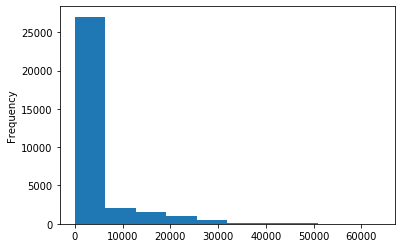

In [156]:
durations['delta'].plot.hist()

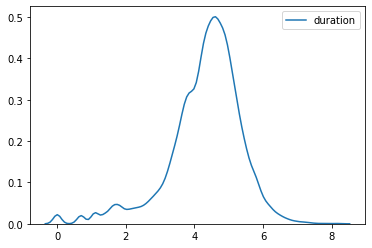

In [188]:
import seaborn
from numpy import log

seaborn.kdeplot(log(durations.loc[durations['duration'] > 0, 'duration']))

In [80]:
activities.groupBy('ActivityType').count().show(truncate=False)

+-------------------------+-------+
|ActivityType             |count  |
+-------------------------+-------+
|Called Vendor            |98457  |
|Received Call / Email    |4075   |
|null                     |1491895|
|Note Only                |25191  |
+-------------------------+-------+



In [ ]:
spark.stop()